In [1]:
%matplotlib inline
import os
import glob
import pandas as pd
import numpy as np
import tables
import seaborn as sns
import matplotlib.pylab as plt
from scipy.signal import medfilt
from tierpsy.analysis.feat_create.obtainFeaturesHelper import WormStats
from scipy.stats import ttest_ind

In [2]:
fps = 25
time_window_s = 10
THRESH = 10

masks_dir = '/Volumes/SAMSUNG_USB/David_Miller/DM_unc-4_Adult_L4_060417/'
results_dir = '/Volumes/SAMSUNG_USB/David_Miller/DM_unc-4_Adult_L4_060417/Results'
#masks_dir = '/Volumes/behavgenom_archive$/Avelino/screening/David_Miller/MaskedVideos/DM_unc-4_Adult_L4_060417'
#results_dir = masks_dir.replace('MaskedVideos', 'Results')

feat_files = glob.glob(os.path.join(results_dir, '*_features.hdf5'))
files_in_set = [[] for n in range(4)]
set_types = ['Adult on food', 'Adult off food','L4 on food', 'L4 off food']
for feat_file in feat_files:
    base_name = os.path.basename(feat_file).replace('_features.hdf5', '')
    
    set_n = int(base_name.partition('_Set')[-1].partition('_')[0])
    files_in_set[set_n-1].append(feat_file)


In [3]:
# feat_file = files_in_set[1][3]

# with pd.HDFStore(feat_file, 'r') as fid:
#     feat_timeseries = fid['/features_timeseries']
        

# for worm_index, tab in feat_timeseries.groupby('worm_index'):
#     yy = tab['midbody_speed']
#     #yy = tab['length']
#     yy_med = medfilt(yy, 13)

#     is_reaction = (yy_med<-THRESH)*10
    

#     feat_timeseries.loc[tab.index, 'is_reaction'] = is_reaction
    
#     plt.figure(figsize=(15,5))
#     plt.plot(yy.values)
#     plt.plot(yy_med)
#     plt.plot(is_reaction)
#     plt.ylim((-20, 20))


In [4]:
def add_is_reaction(feat_timeseries, th, is_reversal):
    feat_timeseries['is_reaction'] = 0
    for worm_index, tab in feat_timeseries.groupby('worm_index'):
        yy = tab['midbody_speed']
        #yy = tab['length']
        yy_med = medfilt(yy, 13)

        if is_reversal:
            feat_timeseries.loc[tab.index, 'is_reaction'] = (yy_med<-th)
        else:
            feat_timeseries.loc[tab.index, 'is_reaction'] = (yy_med>th)

    return feat_timeseries

def calc_n_worms(feat_timeseries):
    n_per_frame = feat_timeseries['timestamp'].value_counts()
    n_per_frame = n_per_frame.values
    if len(n_per_frame) > 0:
        n_worms_estimate = np.percentile(n_per_frame, 99)
    else:
        n_worms_estimate = 0
    return n_worms_estimate


def get_reaction_fraction(feat_timeseries, th, is_reversal, time_window_s, fps, frac_freq = None):
    if frac_freq is None:
        frac_freq = fps

    feat_timeseries = add_is_reaction(feat_timeseries, th, is_reversal)
    n_worms_estimate = calc_n_worms(feat_timeseries)
    
    first_frame = int(feat_timeseries['timestamp'].min())
    last_frame = int(feat_timeseries['timestamp'].max())
    
    frame_win = int((time_window_s)*fps)
    min_traj_size = 0.9*(frame_win+1)

    react_frac = np.full(last_frame+1, np.nan)
    half_win = frame_win//2
    for ini_win in range(first_frame, last_frame-half_win, frac_freq):
        last_win = ini_win + frame_win
        good = (feat_timeseries['timestamp']>=ini_win) & (feat_timeseries['timestamp']<=last_win)

        win_data = feat_timeseries[good]

        #print(ini_win, last_win, win_data.shape)
        good_ind = win_data['worm_index'].value_counts() >= min_traj_size
        valid_ind = good_ind[good_ind.values].index
        good = win_data['worm_index'].isin(valid_ind)
        win_data_v = win_data[good]

        if win_data_v.size == 0:
            continue

        has_event = win_data_v.groupby('worm_index').agg({'is_reaction':np.max})

        react_frac[ini_win + half_win] = np.sum(has_event['is_reaction'])/n_worms_estimate
    
    return react_frac


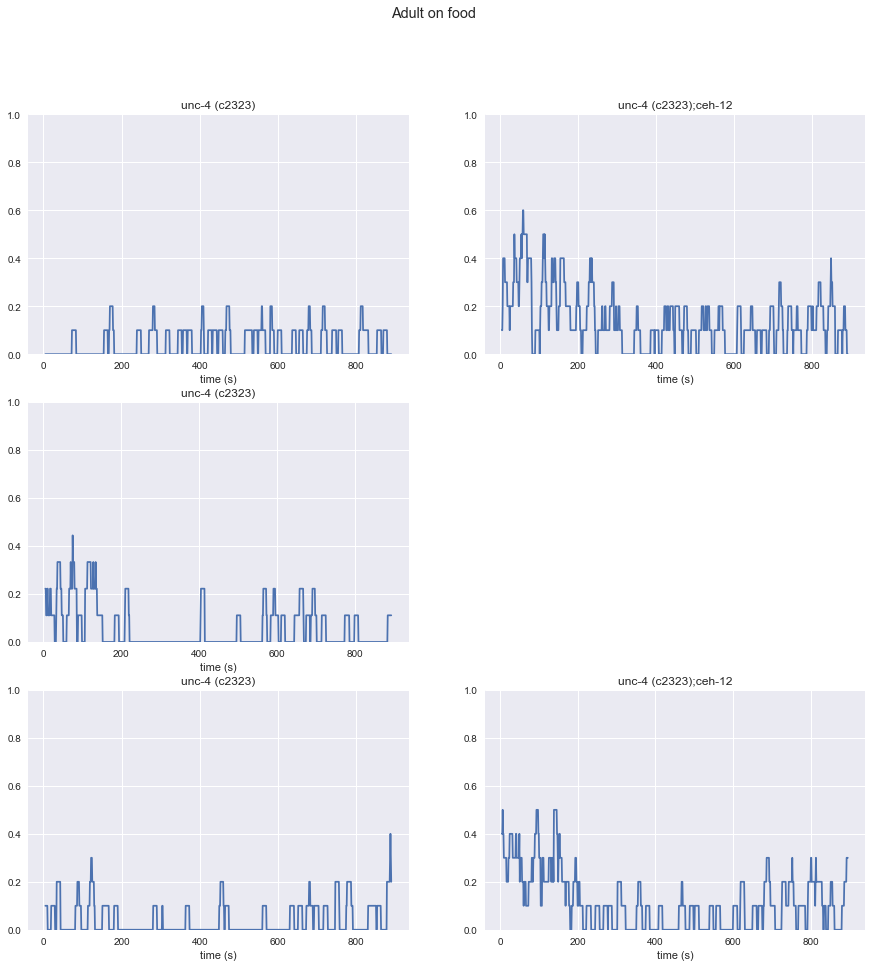

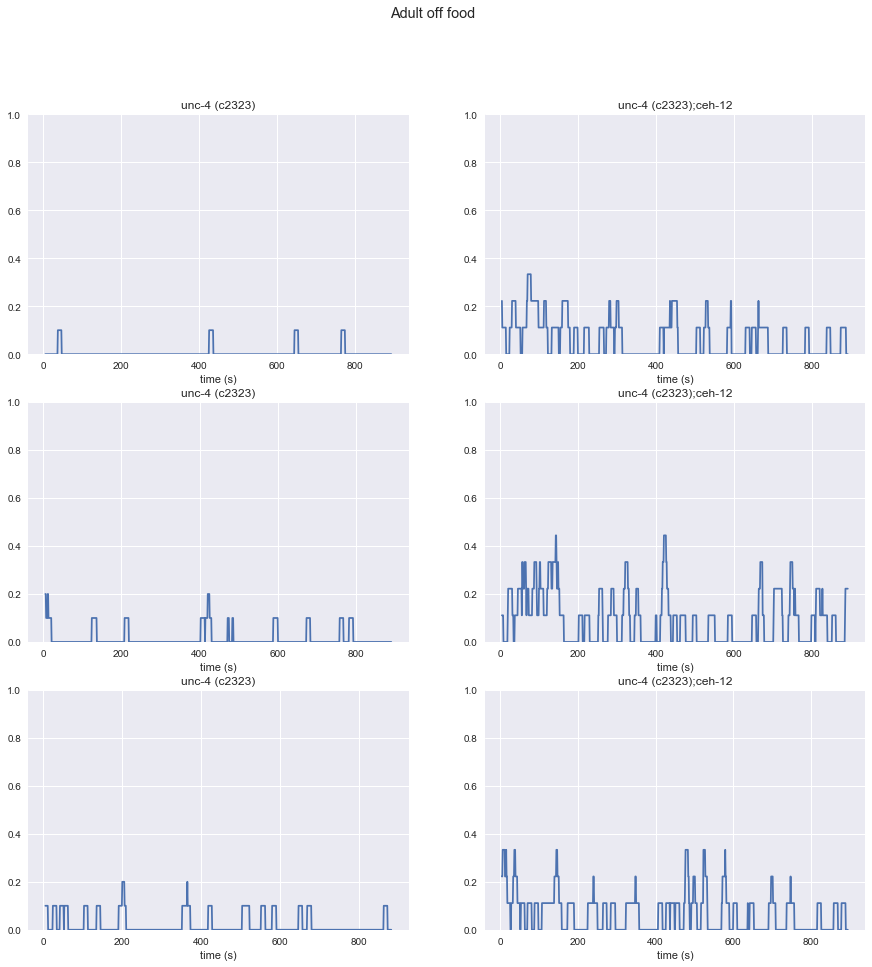

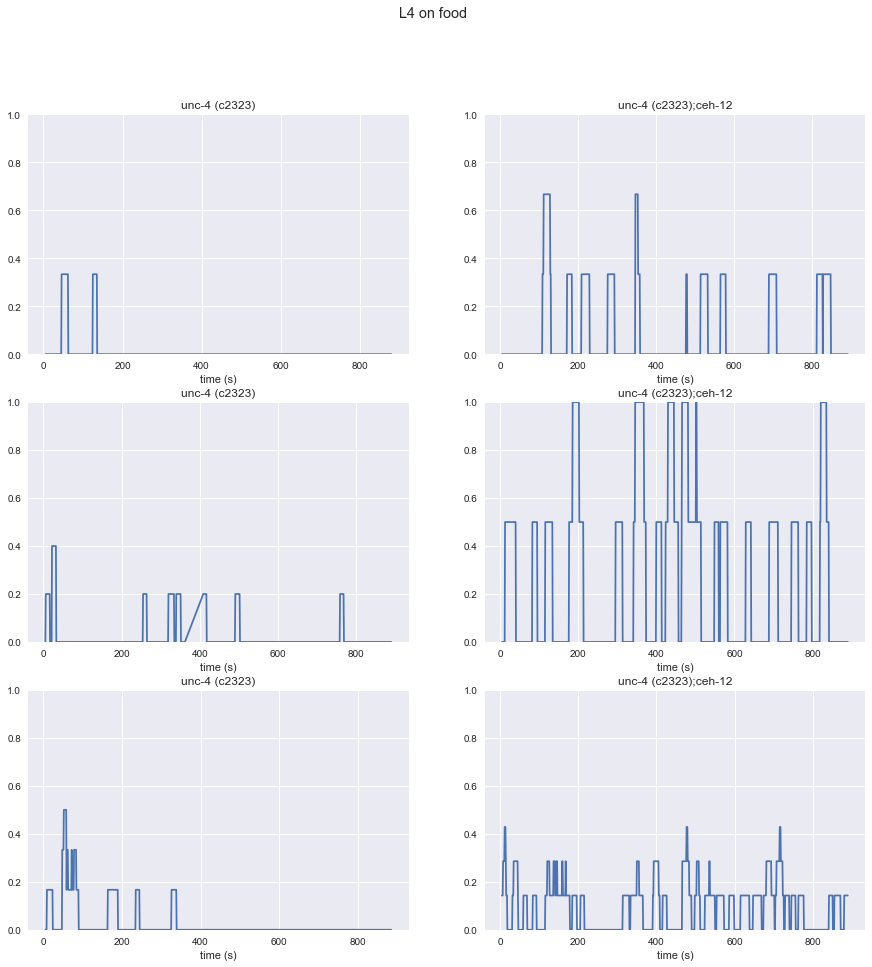

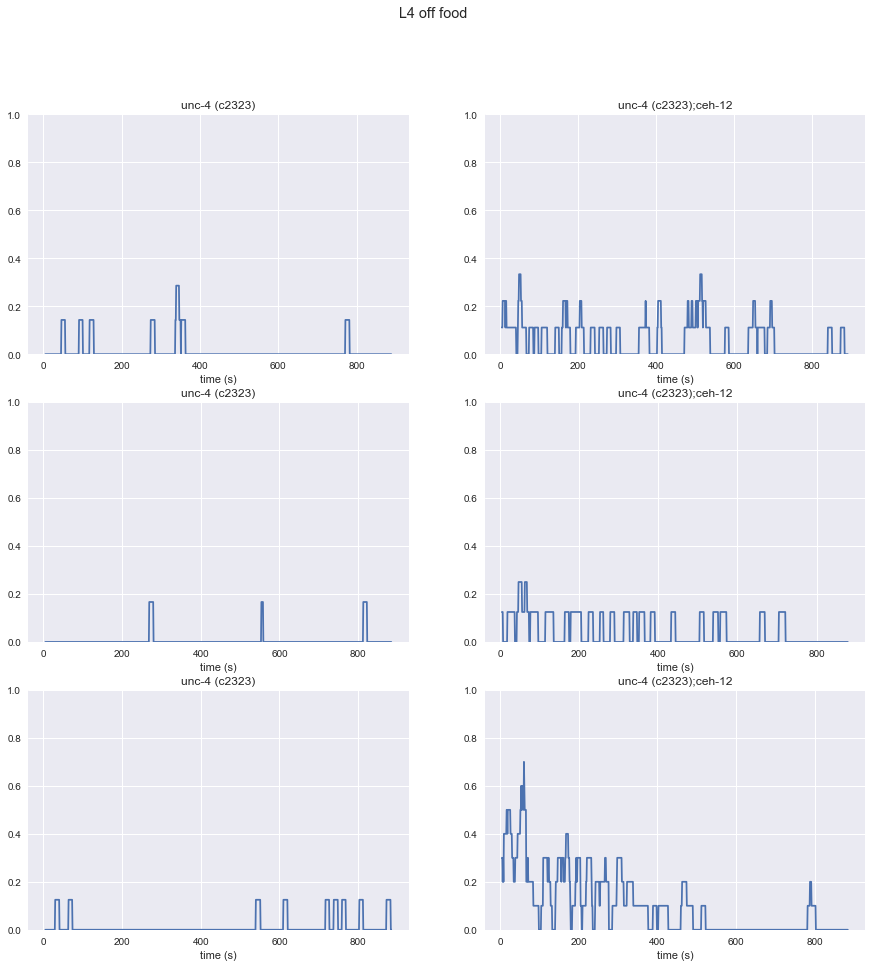

In [5]:
reversal_frac = []
for set_type, feat_files in zip(set_types, files_in_set):
    plt.figure(figsize=(15,15))
    for ii, feat_file in enumerate(feat_files):
        base_name = os.path.basename(feat_file).replace('_features.hdf5', '')
        strain = base_name.split('_')[0]
        
        n_channel = int(base_name.partition('_Ch')[-1].partition('_')[0])
        isub = 2*(n_channel-1)+1 if n_channel <= 3 else 2*(n_channel-3)
        
        with pd.HDFStore(feat_file, 'r') as fid:
            feat_timeseries = fid['/features_timeseries']
        
        rev_frac = get_reaction_fraction(feat_timeseries, 
                                         th=THRESH, 
                                         is_reversal=True, 
                                         time_window_s=time_window_s, 
                                         fps=fps)
        good = ~np.isnan(rev_frac)
        xx = np.where(good)[0]/fps
        yy = rev_frac[good]
        
        plt.subplot(3,2, isub)
        plt.plot(xx, yy)
        
        plt.title(strain)
        plt.xlabel('time (s)')
        plt.ylim((0,1))
        
        reversal_frac.append((set_type, strain, n_channel, np.nanmean(yy)))

    plt.suptitle(set_type)
    
    
reversal_frac = pd.DataFrame(reversal_frac, columns=['conditions', 'strain', 'channel', 'reversal_fraction'])



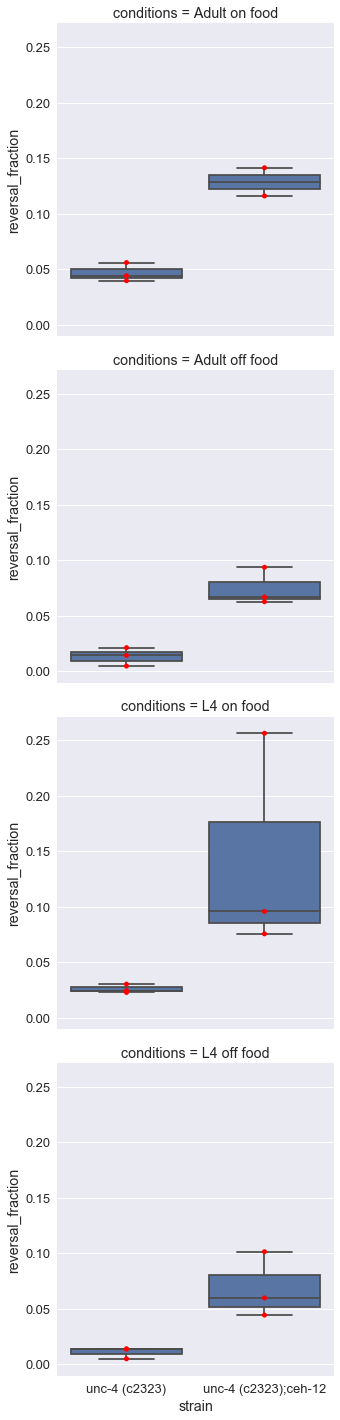

In [6]:
sns.set(font_scale=1.3)
g = sns.FacetGrid(reversal_frac, row="conditions", size=5, aspect=1)
g = g.map(sns.boxplot, "strain", 'reversal_fraction')
g = g.map(sns.stripplot, "strain", 'reversal_fraction', color="r")

In [7]:
p_values = []
for conditions, s_data in reversal_frac.groupby('conditions'):
    fraction_reaction = s_data['reversal_fraction']
    x = fraction_reaction[s_data['strain']=='unc-4 (c2323)'].values
    y = fraction_reaction[s_data['strain']=='unc-4 (c2323);ceh-12'].values

    _, p = ttest_ind(x,y, equal_var=False)

    p_values.append((conditions, p))

p_values = pd.DataFrame(p_values, columns=['condition', 'p_value'])
    
print(p_values)

        condition   p_value
0  Adult off food  0.011884
1   Adult on food  0.065649
2     L4 off food  0.073374
3      L4 on food  0.177862


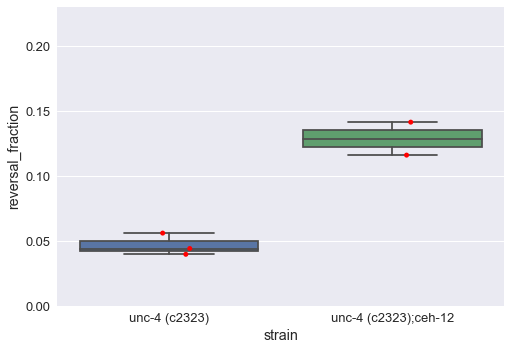

In [8]:
c_data = reversal_frac[reversal_frac['conditions']=='Adult on food']

graph = plt.figure()
sns.boxplot(x='strain', 
            y='reversal_fraction', 
            data=c_data)
sns.stripplot(x='strain', 
              y='reversal_fraction', 
              color='r', 
              jitter=True,
              data=c_data)
plt.ylim((0, 0.23))
from matplotlib.backends.backend_pdf import PdfPages
with PdfPages('unc-4_adult_onfood_spontaneous_backwards.pdf') as pp:
    pp.savefig(graph)


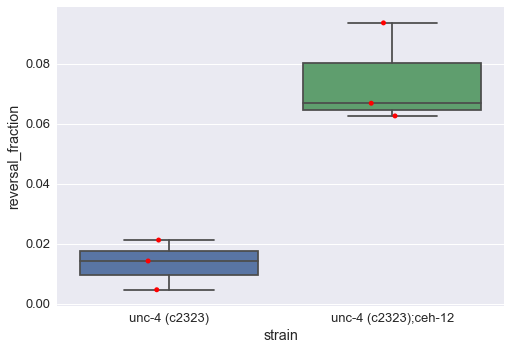

In [9]:
c_data = reversal_frac[reversal_frac['conditions']=='Adult off food']

graph = plt.figure()
sns.boxplot(x='strain', 
            y='reversal_fraction', 
            data=c_data)
sns.stripplot(x='strain', 
              y='reversal_fraction', 
              color='r', 
              jitter=True,
              data=c_data)
#plt.ylim((0, 0.23))
from matplotlib.backends.backend_pdf import PdfPages
with PdfPages('unc-4_adult_offfood_spontaneous_backwards.pdf') as pp:
    pp.savefig(graph)
